In [ ]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [ ]:
file_dir="./cifar-10/data_batch_1"
dict1=unpickle(file_dir)
# dict1
dict1[ b'data'][0].shape
dict1

##对cifar10的二进制数据进行解码成图片

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.misc import imsave
# plt.figure()
file_dir="./cifar-10/test_batch"
dict1=unpickle(file_dir)
for i in range(10000):
    image=np.reshape(dict1[b'data'][i],(3,32,32))
    image=image.transpose(1,2,0)
    print("processing bytesto image: {}".format(i),flush=True)
    label=dict1[b'labels'][i]
    imsave("./cifar10_image_test/{}_{}.png".format(label,i),image)
# print(image.shape)
# plt.imshow(image)
# plt.show()

In [ ]:
###生成训练用的tfrecords  

In [ ]:
import os
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
image_dir="./cifar10_image_test"####图片所在的路径
writer=tf.python_io.TFRecordWriter("cifar10_test.tfrecords")###创建一个writer
global count ###计数值
count=0
for file_name in os.listdir(image_dir):###获取路径下的所有文件的名字（包括后缀）
    global count
    count+=1
    label=file_name.split('_')[0]###这里的label，我在解析数据的时候把label写在了文件名的第一个字符
    image=Image.open(image_dir+'/'+file_name)###打开图片
    image_bytes=image.tobytes()###将图片的数据转化成二进制文件
    example=tf.train.Example(features=tf.train.Features(feature={
        "label":tf.train.Feature(int64_list=tf.train.Int64List(value=[int(label)])),
        "image":tf.train.Feature(bytes_list=tf.train.BytesList(value=[image_bytes]))
    }))
    print("processing image to tfrecords num {}".format(count))
    writer.write(example.SerializeToString())###序列化数据写入tfrecords
writer.close()

In [1]:
def read_decode(filename):
    filename_queue=tf.train.string_input_producer([filename],shuffle=True)#创建一个文件名队列（打乱顺序）
    reader=tf.TFRecordReader()
    _,serialized_example=reader.read(filename_queue)##读取队列数据
    features=tf.parse_single_example(serialized_example,
                                             features={
                                                 "label":tf.FixedLenFeature([],tf.int64),
                                                 "image":tf.FixedLenFeature([],tf.string)
                                             })
    image=tf.decode_raw(features["image"],tf.uint8)##重新编码成图片
    image=tf.reshape(image,[32,32,3])
    image=tf.cast(image,tf.int64)
    label=tf.cast(features['label'],tf.int32)
    print(image,label)
    return image,label

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
filename="cifar10_batch1_train.tfrecords"
raw_image,label=read_decode(filename)

Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Tensor("Cast:0", shape=(32, 32, 3), dtype=int64) Tensor("Cast_1:0", shape=(), dtype=int32)


[array([[[192, 185, 179],
        [193, 186, 180],
        [199, 192, 186],
        ...,
        [220, 212, 191],
        [221, 215, 193],
        [224, 220, 198]],

       [[190, 180, 172],
        [191, 181, 173],
        [198, 188, 180],
        ...,
        [219, 212, 191],
        [220, 214, 191],
        [221, 213, 190]],

       [[191, 179, 169],
        [193, 181, 172],
        [198, 185, 176],
        ...,
        [215, 210, 188],
        [216, 209, 187],
        [212, 200, 178]],

       ...,

       [[110, 114, 115],
        [105, 109, 110],
        [ 84,  88,  88],
        ...,
        [130, 127, 118],
        [124, 122, 110],
        [135, 133, 120]],

       [[116, 120, 119],
        [110, 114, 113],
        [ 99, 103, 102],
        ...,
        [132, 130, 120],
        [132, 130, 118],
        [134, 132, 119]],

       [[107, 111, 113],
        [109, 113, 115],
        [ 97, 101, 103],
        ...,
        [128, 125, 115],
        [141, 139, 126],
        [141, 139, 126]

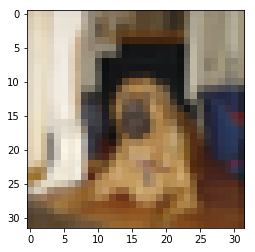

In [4]:
with tf.Session() as sess:
    coord=tf.train.Coordinator()
    threads=tf.train.start_queue_runners(coord=coord)
#     raw_image,label=read_decode(filename)
    print(sess.run([raw_image,label]))
    plt.imshow(raw_image.eval())
    plt.show()
    coord.request_stop()
    coord.join(threads)

In [13]:
def get_batch_cifar10(filename,batchsize):
#     file_name_queue=tf.train.string_input_producer([filename],shuffle=True)
    image,label=read_decode(filename)
    
    min_after_dequeue=1000
    capacity=min_after_dequeue+3*batchsize
    
    image_batch,label_batch=tf.train.shuffle_batch([image,label],batch_size=batchsize,
                                                   capacity=capacity,min_after_dequeue=min_after_dequeue)
    return image_batch,label_batch

Tensor("Cast_20:0", shape=(32, 32, 3), dtype=int64) Tensor("Cast_21:0", shape=(), dtype=int32)


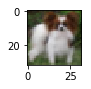

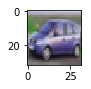

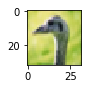

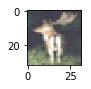

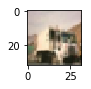

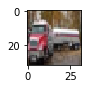

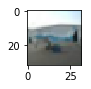

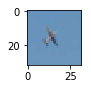

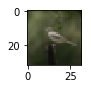

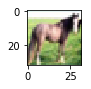

In [23]:
init=tf.global_variables_initializer()
image_batch,label_batch=get_batch_cifar10("./cifar10_batch1_train.tfrecords",batchsize=1)
with tf.Session() as sess:
    sess.run(init)
    coord=tf.train.Coordinator()###创建一个协调器，管理线程
    threads=tf.train.start_queue_runners(sess,coord)#启动队列
    
    for i in range(10):
        batch_image,batch_label=sess.run([image_batch,label_batch])
        plt.figure(figsize=(1,1))
        plt.imshow(np.reshape(batch_image,(32,32,3)))
        plt.show()
    coord.request_stop()
    coord.join(threads)